In [ ]:
# =====================
# Section: Setup and Imports
# Written by: Chris Vallas
# =====================
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score


Mounted at /content/drive


In [ ]:
import os

benign_imgs = os.listdir(os.path.join(train_dir, 'benign'))
malignant_imgs = os.listdir(os.path.join(train_dir, 'malignant'))

print("Benign image files:")
print(sorted(benign_imgs[:5]))  # sample
print(f"Total benign: {len(benign_imgs)}")

print("\nMalignant image files:")
print(sorted(malignant_imgs[:5]))  # sample
print(f"Total malignant: {len(malignant_imgs)}")


Benign image files:
['1500.jpg', '1507.jpg', '152.jpg', '1523.jpg', '153.jpg']
Total benign: 1440

Malignant image files:
['1177.jpg', '118.jpg', '1207.jpg', '1222.jpg', '1239.jpg']
Total malignant: 1197


In [ ]:
# =====================
# Section: Data Loading and Visualization
# Written by: Chris Vallas
# =====================
# Set paths to training and test data
train_dir = '/content/drive/MyDrive/skin_cancer/train'
test_dir = '/content/drive/MyDrive/skin_cancer/test'

# Print number of samples per class
benign_count = len(os.listdir(os.path.join(train_dir, 'benign')))
malignant_count = len(os.listdir(os.path.join(train_dir, 'malignant')))
print(f"Benign: {benign_count}, Malignant: {malignant_count}")


Benign: 1440, Malignant: 1197


In [ ]:
# =====================
# Section: Data Preprocessing (ImageDataGenerator)
# Written by: Jaynil Patel
# =====================
# Data augmentation for training + validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Class info
print("Class indices:", train_generator.class_indices)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Class indices: {'benign': 0, 'malignant': 1}


In [ ]:
# =====================
# Section: Class Balancing
# Written by: Chris Vallas
# =====================
# Automatically balance classes
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.9157986111111112), 1: np.float64(1.1012526096033404)}


In [ ]:
# =====================
# Section: Model Building and Base Training
# Written by: Jaynil Patel
# =====================
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint_cb = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history_base = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weights
)

model.save('resnet_base_model.keras')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
66/66 ━━━━━━━━━━━━━━━━━━━━ 998s 15s/step - accuracy: 0.5096 - loss: 0.8101 - val_accuracy: 0.4535 - val_loss: 0.7036
Epoch 2/3
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 601ms/step - accuracy: 0.5027 - loss: 0.7128 - val_accuracy: 0.6034 - val_loss: 0.6910
Epoch 3/3
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 594ms/step - accuracy: 0.5173 - loss: 0.6939 - val_accuracy: 0.4535 - val_loss: 0.6934
Restoring model weights from the end of the best epoch: 2.


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
Base Model Classification Report:
              precision    recall  f1-score   support

      benign       0.60      0.92      0.72       360
   malignant       0.73      0.26      0.38       300

    accuracy                           0.62       660
   macro avg       0.66      0.59      0.55       660
weighted avg       0.66      0.62      0.57       660



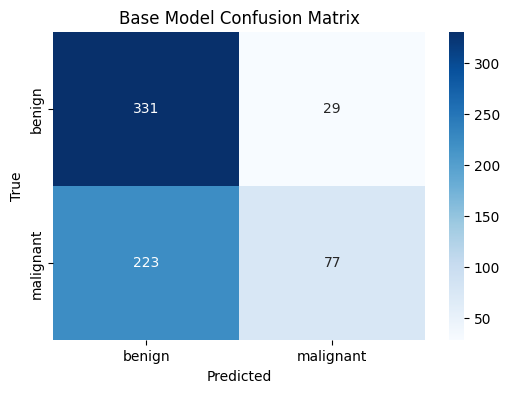

In [ ]:
# =====================
# Section: Base Model Evaluation and Metrics
# Written by: Chris Vallas
# =====================
# Save base model before fine-tuning
model.save('resnet_base_model.keras')

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Evaluate Base Model
base_predictions = model.predict(test_generator)
base_pred_classes = (base_predictions > 0.5).astype('int32').flatten()
true_classes = test_generator.classes

print("Base Model Classification Report:")
print(classification_report(true_classes, base_pred_classes, target_names=class_labels))


base_cm = confusion_matrix(test_generator.classes, base_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Base Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# =====================
# Section: Fine-Tuning Top 50 Layers
# Written by: Jaynil Patel
# =====================
# Unfreeze the top 50 layers of the base model for fine-tuning
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint_cb],
    class_weight=class_weights
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 606ms/step - accuracy: 0.7863 - loss: 0.4612 - val_accuracy: 0.6736 - val_loss: 0.6847
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 609ms/step - accuracy: 0.7860 - loss: 0.4443 - val_accuracy: 0.7970 - val_loss: 0.4177
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 579ms/step - accuracy: 0.8084 - loss: 0.4319 - val_accuracy: 0.8027 - val_loss: 0.4466
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 581ms/step - accuracy: 0.7957 - loss: 0.4386 - val_accuracy: 0.7268 - val_loss: 0.5904
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 586ms/step - accuracy: 0.7906 - loss: 0.4324 - val_accuracy: 0.7306 - val_loss: 0.5471
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
print("Evaluating Fine-Tuned Model on Test Set...")


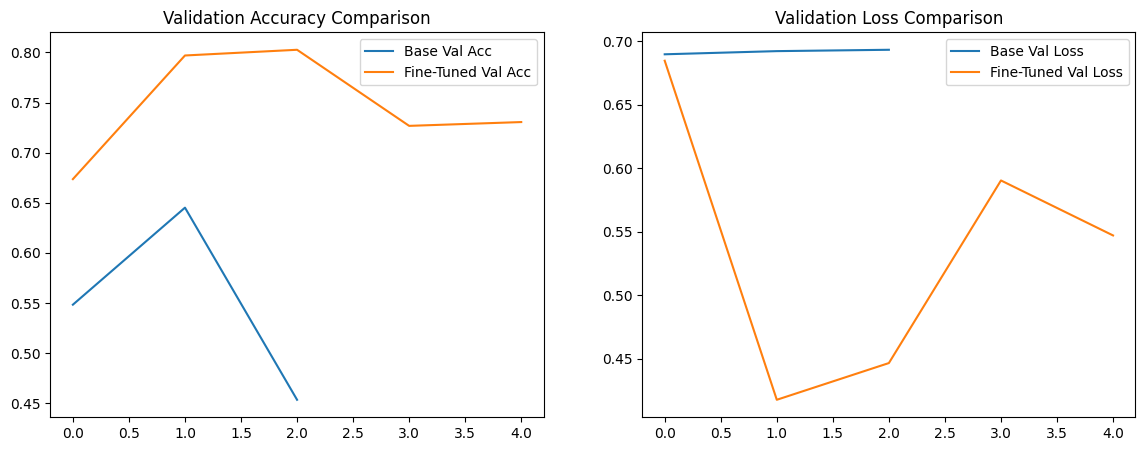

In [ ]:
# =====================
# Section: Graph Comparison of Base vs Fine-Tuned
# Written by: Chris Vallas
# =====================
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base.history['val_accuracy'], label='Base Val Acc')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Val Acc')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base.history['val_loss'], label='Base Val Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuned Val Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.show()


In [ ]:
# =====================
# Section: Final Evaluation Metrics and Visualization
# Written by: Chris Vallas
# =====================
from sklearn.metrics import precision_score, recall_score, f1_score

# Base model scores
base_precision = precision_score(test_generator.classes, base_pred_classes)
base_recall = recall_score(test_generator.classes, base_pred_classes)
base_f1 = f1_score(test_generator.classes, base_pred_classes)

# Fine-tuned model scores (already calculated)
print("\nComparison of Metrics:")
print(f"Precision - Base: {base_precision:.2f} vs Fine-Tuned: {precision:.2f}")
print(f"Recall    - Base: {base_recall:.2f} vs Fine-Tuned: {recall:.2f}")
print(f"F1 Score  - Base: {base_f1:.2f} vs Fine-Tuned: {f1:.2f}")


NameError: name 'test_generator' is not defined

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


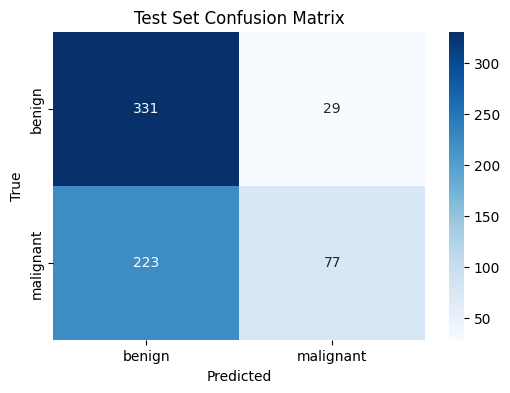

In [ ]:
# Predict
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32').flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()


In [ ]:
# Evaluation Metrics
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Precision: 0.7330
Recall:    0.8967
F1 Score:  0.8066
              precision    recall  f1-score   support

      benign       0.89      0.73      0.80       360
   malignant       0.73      0.90      0.81       300

    accuracy                           0.80       660
   macro avg       0.81      0.81      0.80       660
weighted avg       0.82      0.80      0.80       660



Need to compare new graphs to old graphs of untrained model.